# Datset: Pairwise approach

Get tracksters from a certain neighbourhood.

Neighbourhood:
- get links from ticlNtuplizer/graph
    - figure out how these links are formed
- convert the tracksters into some latent space and predict a link between them
- later extend this using edgeconv or sageconf to add information from the neighbourhood

Graph:
- linked_inners
    - nodes linked to the given tracksters within its cone


In [23]:
import uproot
import torch
import random
import numpy as np

from reco.distance import euclidian_distance
from reco.matching import find_good_pairs
from reco.dataset import match_trackster_pairs, TracksterPairs
from reco.plotting import plot_tracksters
from reco.event import get_bary


import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8-whitegrid')

data_root = "/mnt/ceph/users/ecuba/processed"
raw_dir = "/mnt/ceph/users/ecuba/multiparticle_10/"
file_name = f"{raw_dir}/new_ntuples_14992862_101.root"

tracksters = uproot.open({file_name: "ticlNtuplizer/tracksters"})
simtracksters = uproot.open({file_name: "ticlNtuplizer/simtrackstersSC"})
associations = uproot.open({file_name: "ticlNtuplizer/associations"})
graph = uproot.open({file_name: "ticlNtuplizer/graph"})

In [24]:
eid = 0

# prepare distance points
vx = tracksters["vertices_x"].array()[eid]
vy = tracksters["vertices_y"].array()[eid]
vz = tracksters["vertices_z"].array()[eid]
ve = tracksters["vertices_energy"].array()[eid]
clouds = [np.array([vx[tid], vy[tid], vz[tid]]).T for tid in range(len(vx))]

## Candidate pairs

Compile a list of candidate pairs based on the CLUE3D graph and node distance.

Reject all nodes with above a distance threshold.

In [25]:
MAX_DISTANCE = 14   # cm

candidate_pairs = []
distances = []

inners_list = graph["linked_inners"].array()[eid]
for i, inners in enumerate(inners_list):
    for inner in inners:
        dst = euclidian_distance(clouds[i], clouds[inner])
        distances.append(dst)
        if dst <= MAX_DISTANCE:
            candidate_pairs.append((i, inner))
            
print("Candidate pairs:", len(candidate_pairs))

Candidate pairs: 119


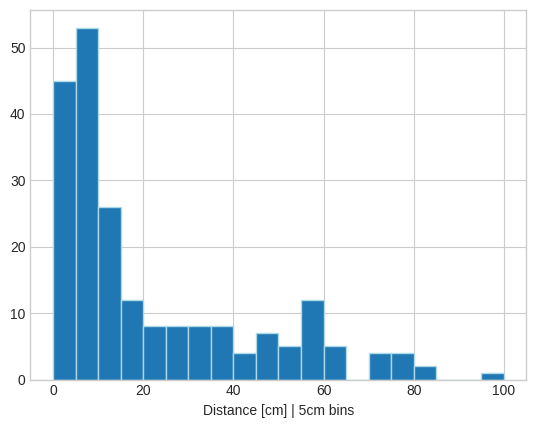

In [26]:
plt.hist(distances, bins=20, edgecolor="lightblue", range=(0, 100))
plt.xlabel("Distance [cm] | 5cm bins")
plt.show()

## Ground truth

In [27]:
gt_pairs = match_trackster_pairs(
    tracksters,
    simtracksters,
    associations,
    eid,
    distance_threshold=MAX_DISTANCE,
)
print("Ground truth pairs:", len(gt_pairs))

Ground truth pairs: 34


In [28]:
# sanity check
# all gold pairs are present in the candidate pairs

ab_pairs = set([(a, b) for a, b, _ in gt_pairs])
ba_pairs = set([(b, a) for a, b, _ in gt_pairs])
c_pairs = set(candidate_pairs)

matches = ab_pairs.union(ba_pairs).intersection(c_pairs)
not_matches = c_pairs - matches

# edges that are not the best but still correct
neutral = find_good_pairs(tracksters, associations, not_matches, eid)
positive = list(matches)
negative = random.sample(list(not_matches-neutral), k=len(matches))

print(f"positive: {len(positive)} negative: {len(not_matches)} negative selected: {len(set(negative))} neutral: {len(neutral)}")
# assert len(matches) == len(gt_pairs)

positive: 30 negative: 89 negative selected: 30 neutral: 1


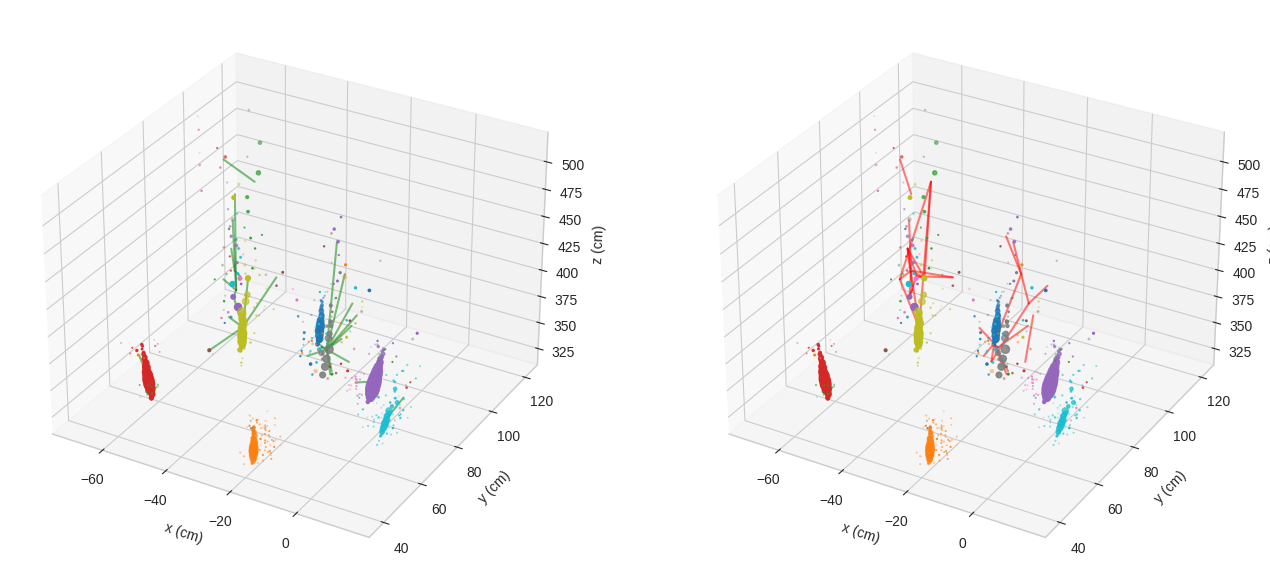

In [29]:
fig = plt.figure(figsize=(16, 8))
ax1 = fig.add_subplot(121, projection='3d')
ax2 = fig.add_subplot(122, projection='3d')
plot_tracksters(ax1, vx, vy, vz, ve)
plot_tracksters(ax2, vx, vy, vz, ve)
bary = get_bary(tracksters, eid)

def plot_edge(ax, edge, color):
    a, b = edge
    ca = bary[a]
    cb = bary[b]
    x = (ca[0], cb[0])
    y = (ca[1], cb[1])
    z = (ca[2], cb[2])
    ax.plot(x, y, z, c=color, alpha=0.5)

for edge in positive:
    plot_edge(ax1, edge, "green")

for edge in negative:
    plot_edge(ax2, edge, "red")

plt.show()

## Dataset

In [ ]:
ds = TracksterPairs(
    data_root,
    raw_dir,
    N_FILES=200,
    balanced=False,
    include_neutral=False,
    MAX_DISTANCE=15,
    ENERGY_THRESHOLD=20
)
ds

Processing: /mnt/ceph/users/ecuba/multiparticle_10/new_ntuples_14992862_137.root
Processing: /mnt/ceph/users/ecuba/multiparticle_10/new_ntuples_14992862_1230.root
Processing: /mnt/ceph/users/ecuba/multiparticle_10/new_ntuples_14992862_1387.root
Processing: /mnt/ceph/users/ecuba/multiparticle_10/new_ntuples_14992862_1333.root
Processing: /mnt/ceph/users/ecuba/multiparticle_10/new_ntuples_14992862_1233.root
Processing: /mnt/ceph/users/ecuba/multiparticle_10/new_ntuples_14992862_1364.root
Processing: /mnt/ceph/users/ecuba/multiparticle_10/new_ntuples_14992862_1142.root
Processing: /mnt/ceph/users/ecuba/multiparticle_10/new_ntuples_14992862_1030.root
Processing: /mnt/ceph/users/ecuba/multiparticle_10/new_ntuples_14992862_1152.root
Processing: /mnt/ceph/users/ecuba/multiparticle_10/new_ntuples_14992862_1131.root
Processing: /mnt/ceph/users/ecuba/multiparticle_10/new_ntuples_14992862_1092.root
Processing: /mnt/ceph/users/ecuba/multiparticle_10/new_ntuples_14992862_1026.root
Processing: /mnt/

In [10]:
ds[0]

(tensor([-4.8992e+01, -8.2181e+01,  3.6458e+02,  1.7292e+00,  8.4644e-01,
          2.1322e+01,  1.9918e+00,  1.9054e-13, -2.6395e-01, -4.0296e-01,
          8.7633e-01,  2.8591e+00,  2.3861e+00,  3.0734e+00, -4.8055e+01,
         -7.5214e+01,  3.3955e+02,  3.4745e+02,  3.4745e+02,  4.4699e+01,
          3.7576e-02,  1.0242e-02, -1.3572e-01, -2.2101e-01,  9.6578e-01,
          6.6266e+00,  6.5131e-01,  6.4109e-01,  3.0000e+00,  2.8000e+01,
          2.7339e+00]),
 tensor(1.))

## Dummy evaluation

Let's talk baselines on this dataset. How good is a random guess?
How good is connecting to all nodes in a neighbourhood?

In [11]:
from reco.evaluation import pairwise_model_evaluation

In [12]:
class DummyModel:
    def eval(self):
        pass

class DummyPleaser(DummyModel):
    def __call__(self, X):
        return torch.tensor(np.ones(len(X)))

class DummyGuesser(DummyModel):
    def __call__(self, X):
        return torch.tensor(np.random.random(len(X)))

class DummyScaler:
    def transform(self, X):
        return X.tolist()

In [ ]:
result = pairwise_model_evaluation(
    tracksters,
    simtracksters,
    associations,
    graph,
    DummyPleaser(),
    DummyScaler(),
    0.5,
    max_distance=15,
    energy_threshold=20,
)

Event 0:
	clue3d_to_sim:	P: 1.00 R: 0.63 F: 0.68
	target_to_sim:	P: 1.00 R: 0.91 F: 0.93
	reco_to_target:	P: 0.96 R: 0.88 F: 0.89
	reco_to_sim:	P: 1.00 R: 0.80 F: 0.83
Event 1:
	clue3d_to_sim:	P: 1.00 R: 0.53 F: 0.58
	target_to_sim:	P: 1.00 R: 0.76 F: 0.80
	reco_to_target:	P: 0.93 R: 0.88 F: 0.89
	reco_to_sim:	P: 0.99 R: 0.73 F: 0.77
Event 2:
	clue3d_to_sim:	P: 0.94 R: 0.20 F: 0.24
	target_to_sim:	P: 0.95 R: 0.52 F: 0.57
	reco_to_target:	P: 0.76 R: 0.76 F: 0.76
	reco_to_sim:	P: 0.90 R: 0.47 F: 0.52
Event 3:
	clue3d_to_sim:	P: 0.97 R: 0.21 F: 0.24
	target_to_sim:	P: 0.98 R: 0.59 F: 0.64
	reco_to_target:	P: 0.89 R: 0.78 F: 0.80
	reco_to_sim:	P: 0.96 R: 0.54 F: 0.59
Event 4:
	clue3d_to_sim:	P: 0.96 R: 0.16 F: 0.19
	target_to_sim:	P: 0.97 R: 0.55 F: 0.60
	reco_to_target:	P: 0.90 R: 0.83 F: 0.85
	reco_to_sim:	P: 0.96 R: 0.49 F: 0.55
Event 5:
	clue3d_to_sim:	P: 0.98 R: 0.34 F: 0.39
	target_to_sim:	P: 0.97 R: 0.69 F: 0.74
	reco_to_target:	P: 0.88 R: 0.87 F: 0.87
	reco_to_sim:	P: 0.97 R: 0.64 

In [ ]:
for key, values in result.items():
    avg_p = np.mean([x[0] for x in values])
    avg_r = np.mean([x[1] for x in values])
    avg_f = np.mean([x[2] for x in values])

    print(f"mean {key}:\tP: {avg_p:.2f} R: {avg_r:.2f} F: {avg_f:.2f}")